**We are fine-tuning DistilBERT for cyberbullying detection. DistilBERT, a compact and efficient variant of BERT, achieves 97% of BERT's performance while being faster and utilizing fewer parameters. This makes it an ideal choice for deploying sophisticated NLP models in resource-constrained environments without compromising on accuracy.**

we will build a machine learning model to classify cyberbullying content into different categories using the DistilBERT model. We will use Optuna, a powerful hyperparameter optimization framework, to fine-tune our model's performance. The entire process includes data preparation, model training, hyperparameter optimization, and evaluation using metrics such as accuracy, precision, recall, and F1 score.

# **Importing necessary libraries and Project Setup**

In [1]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from torch.utils.data import Dataset, DataLoader
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import optuna
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [3]:
bullying_data = pd.read_csv("/content/cb_multi_labeled_balanced.csv")
bullying_data.head()

,text,label
0,@ZubearSays Any real nigga isn't letting this ...,ethnicity/race
1,@MoradoSkittle @prolifejewess @DAConsult @Kell...,not_cyberbullying
2,"the only thing i wish, i wish a nigga would",ethnicity/race
3,You saudias are not friends of Muslim idiots c...,religion
4,@JaydenT2399 @TractorLaw @holmes_gael @erconge...,religion


# **Feature Engineering**

First we have to visualize the label feature and identify the number of classes and its distribution.

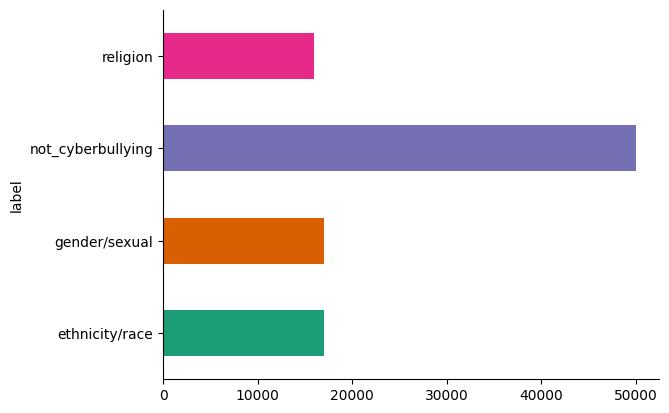

In [4]:
bullying_data.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [5]:
bullying_data['label'].describe()

,label
count,99990
unique,4
top,not_cyberbullying
freq,50000


In [6]:
bullying_data.groupby('label').size()

,0
label,
ethnicity/race,17000
gender/sexual,17000
not_cyberbullying,50000
religion,15990


In [7]:
# Data cleaning function
def clean_text(text):
    import re
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    text = text.lower().strip()
    return text

bullying_data['text_clean'] = bullying_data['text'].apply(clean_text)

In [8]:
bullying_data.drop_duplicates(subset = ['text'], inplace = True)
bullying_data.dropna(inplace = True)

In [9]:
bullying_data['label'].nunique()

4

*These EDA steps will help you understand the structure and key characteristics of your dataset. Based on the insights gained, you can make informed decisions about preprocessing, feature engineering, and model selection.*

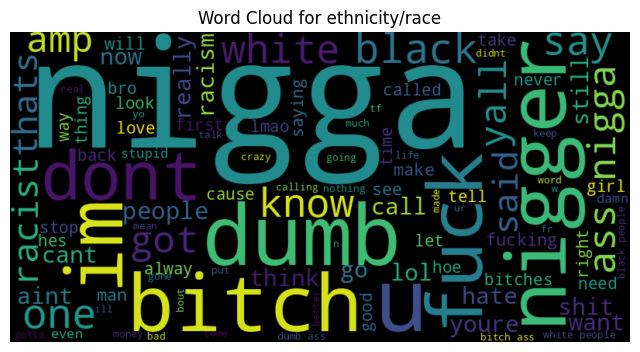

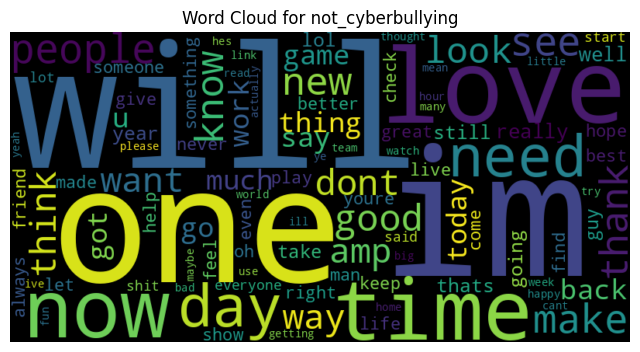

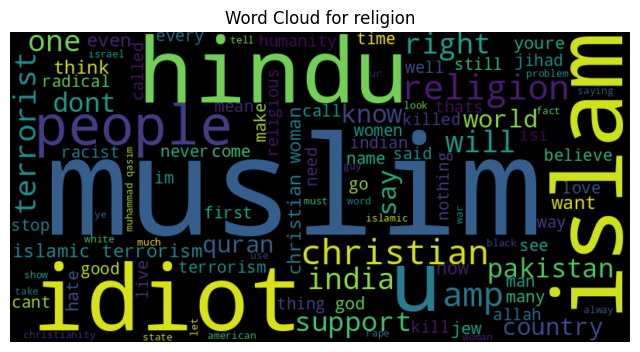

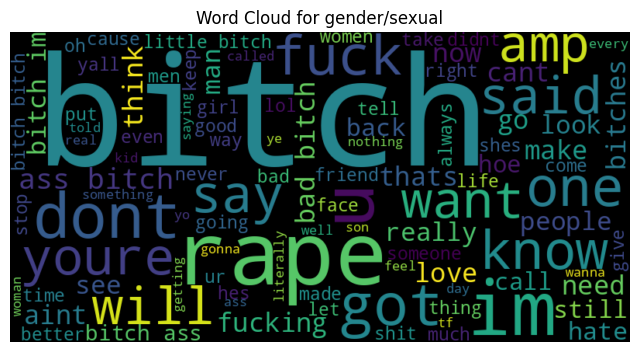

In [10]:
# Word Cloud for each class
for label in bullying_data['label'].unique():
    plt.figure(figsize=(8,6))
    wc = WordCloud(width=800, height=400, max_words=100).generate(' '.join(bullying_data[bullying_data['label'] == label]['text_clean']))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'Word Cloud for {label}')
    plt.axis('off')
    plt.show()

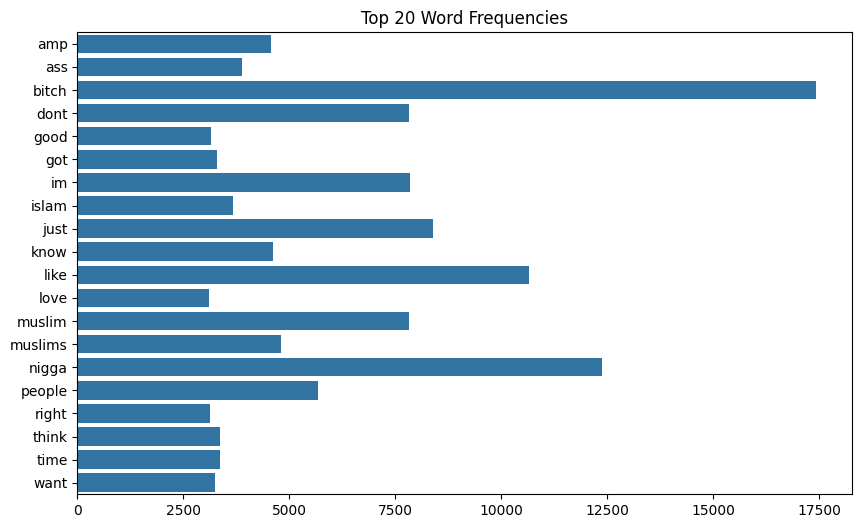

In [11]:
# Word Frequency
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=20)
X_counts = vectorizer.fit_transform(bullying_data['text_clean'])
word_freq = dict(zip(vectorizer.get_feature_names_out(), X_counts.sum(axis=0).tolist()[0]))

plt.figure(figsize=(10,6))
sns.barplot(x=list(word_freq.values()), y=list(word_freq.keys()))
plt.title('Top 20 Word Frequencies')
plt.show()

In [12]:
# Encode the labels
label_encoder = LabelEncoder()
bullying_data['label_encoded'] = label_encoder.fit_transform(bullying_data['label'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(bullying_data['text_clean'], bullying_data['label_encoded'], test_size=0.2, random_state=42, stratify=bullying_data['label_encoded'])


# **Tokenization**

Tokenization, in the realm of Natural Language Processing (NLP) and machine learning, refers to the process of converting a sequence of text into smaller parts, known as tokens. These tokens can be as small as characters or as long as words. The primary reason this process matters is that it helps machines understand human language by breaking it down into bite-sized pieces, which are easier to analyze.




**Tokenization:** The input text is tokenized using the DistilBERT tokenizer, which converts text into tokens that correspond to the vocabulary used during pretraining.
Padding and Truncation: The tokenized inputs are padded to a fixed length and truncated if they exceed the maximum length, ensuring uniform input sizes for the model.


In [13]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenization
def tokenize_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

train_encodings = tokenize_function(X_train.tolist())
test_encodings = tokenize_function(X_test.tolist())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [14]:
#Creating the dataset for model training and relevent to DistilBert configurations
class CyberbullyingDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create dataset objects
train_dataset = CyberbullyingDataset(train_encodings, y_train.tolist())
test_dataset = CyberbullyingDataset(test_encodings, y_test.tolist())

# **Model Architecture and Development**

**Embedding Layer:** The input tokens are converted into dense vector representations using an embedding layer.
Transformer Encoder Layers: The embedding vectors are passed through multiple layers of self-attention and feed-forward networks. Each layer consists of:

Self-Attention Mechanism: This mechanism allows the model to focus on different parts of the input sequence, effectively capturing context and relationships between words.

Feed-Forward Networks: After the attention mechanism, the vectors are passed through fully connected feed-forward networks, applying non-linear transformations.

Distillation: While retaining the essential architecture of BERT, DistilBERT is trained to imitate BERT's output, leading to a smaller but powerful model.
Classification Head:


**CLS Token Representation:** For classification tasks, the output corresponding to the [CLS] token (the first token in the input sequence) is typically used as the aggregate representation of the input text.

Fully Connected Layer: The [CLS] token's output is fed into a fully connected layer, which maps the dense vector representation to the desired number of output classes (in this case, the different cyberbullying categories).

Softmax Activation: The final layer uses a softmax function to convert the logits into probabilities for each class, allowing the model to make a classification decision.
Loss Function:

**Cross-Entropy Loss:** During training, the model's predictions are compared to the true labels using cross-entropy loss, which measures the difference between the predicted probability distribution and the actual distribution.

# **Hyperparameter Optimization using OPTUNA**

We would be using OPTUNA Hyperparameter optimization tool for the selection of best combination of parameters

Optuna is an excellent tool for hyperparameter optimization that uses efficient search algorithms like Tree-structured Parzen Estimator (TPE) to find the best hyperparameters. For the Cyberbullying detection project we have optimized the parameters with OPTUNA for DistilBERT fine-tuning process.

Next, we have utilized Early Stopping Callback to avoid overfitting.

In [15]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }


Next, we define Objective function. The objective function defines how the model is trained and evaluated for different hyperparameter combinations.

In [16]:
def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    weight_decay = trial.suggest_float("weight_decay", 0.01, 0.3)
    num_train_epochs = trial.suggest_int("num_train_epochs", 2, 5)

    # Model Initialization
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))

    # Training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2,
        warmup_steps=500,
        weight_decay=weight_decay,
        learning_rate=learning_rate,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    )

    #Used to save training time and unecessary epochs which were taking the model to take longer while training
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=3,  # Stop training if no improvement after 3 epochs
        early_stopping_threshold=0.0  # Threshold for improvement
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,  # Add the compute_metrics function
        callbacks=[early_stopping_callback]  # Add the early stopping callback
    )

    # Training
    trainer.train()

    # Evaluation
    eval_result = trainer.evaluate()
    return eval_result['eval_loss']  # Use evaluation metric (e.g., loss) as the objective

# Create a study object
study = optuna.create_study(direction="minimize")  # "minimize" because we want to minimize the loss
study.optimize(objective, n_trials=2)  # we can increase n_trials for better optimization


[I 2024-08-20 15:52:06,462] A new study created in memory with name: no-name-e3fe86b7-c393-44ba-b038-7baf8f63d87e


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.018000,0.017334,0.997100,0.997103,0.997100,0.997096
2,0.000100,0.015918,0.997450,0.997451,0.997450,0.997448
3,0.000000,0.017791,0.997550,0.997550,0.997550,0.997548


[I 2024-08-20 16:49:52,265] Trial 0 finished with value: 0.015917738899588585 and parameters: {'learning_rate': 1.19905577779349e-05, 'batch_size': 8, 'weight_decay': 0.11487354790101442, 'num_train_epochs': 3}. Best is trial 0 with value: 0.015917738899588585.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000900,0.018443,0.996650,0.996653,0.996650,0.996646
2,0.002900,0.016899,0.996950,0.996952,0.996950,0.996948
3,0.000100,0.017678,0.997400,0.997399,0.997400,0.997399
4,0.000000,0.021959,0.997500,0.997500,0.997500,0.997498


[I 2024-08-20 17:57:00,953] Trial 1 finished with value: 0.01689932681620121 and parameters: {'learning_rate': 1.9103259418310065e-05, 'batch_size': 16, 'weight_decay': 0.07001350726916031, 'num_train_epochs': 4}. Best is trial 0 with value: 0.015917738899588585.


In [17]:
print(f"Best trial: {study.best_trial.value}")
print(f"Best hyperparameters: {study.best_trial.params}")

Best trial: 0.015917738899588585
Best hyperparameters: {'learning_rate': 1.19905577779349e-05, 'batch_size': 8, 'weight_decay': 0.11487354790101442, 'num_train_epochs': 3}


# **Fine Tuning the Model with DistilBert**

Fine-tuning involves training the pre-trained DistilBERT model on our specific dataset for the cyberbullying classification task. During fine-tuning:

**Transfer Learning:** The model leverages the knowledge gained during pretraining on large text corpora and adapts it to our smaller, domain-specific dataset.

**Hyperparameter Tuning:** Hyperparameters such as learning rate, batch size, and weight decay are optimized using Optuna, improving the model's performance.

**Early Stopping:** We implement early stopping to prevent overfitting, ensuring that the model does not train for more epochs than necessary if validation performance stops improving.

We would select the best cobination of hyperparameters which we got with OPTUNA.

Once the optimization is complete, we can use the best hyperparameters to retrain your model or continue training from the last checkpoint.

In [18]:
# Get the best hyperparameters
best_params = study.best_trial.params

# Retrain the model with the best hyperparameters
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=best_params['num_train_epochs'],
    per_device_train_batch_size=best_params['batch_size'],
    per_device_eval_batch_size=best_params['batch_size'] * 2,
    warmup_steps=500,
    weight_decay=best_params['weight_decay'],
    learning_rate=best_params['learning_rate'],
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=3,  # Stop training if no improvement after 3 epochs
        early_stopping_threshold=0.0  # Threshold for improvement
    )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,  # Add the compute_metrics function
    callbacks=[early_stopping_callback]  # Add the early stopping callback
)

trainer.train()
final_eval_results = trainer.evaluate()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000300,0.019217,0.996850,0.996852,0.996850,0.996846
2,0.001800,0.019161,0.996950,0.996949,0.996950,0.996949
3,0.000000,0.018154,0.997650,0.997650,0.997650,0.997648


In [19]:
print(f"Accuracy: {final_eval_results['eval_accuracy']}")
print(f"Precision: {final_eval_results['eval_precision']}")
print(f"Recall: {final_eval_results['eval_recall']}")
print(f"F1 Score: {final_eval_results['eval_f1']}")

Accuracy: 0.9976497649764976
Precision: 0.9976496041703783
Recall: 0.9976497649764976
F1 Score: 0.9976484915756537


In [20]:
# Save the model and tokenizer
model.save_pretrained('./distilbert-cyberbullying-model')
tokenizer.save_pretrained('./distilbert-cyberbullying-tokenizer')

('./distilbert-cyberbullying-tokenizer/tokenizer_config.json',
 './distilbert-cyberbullying-tokenizer/special_tokens_map.json',
 './distilbert-cyberbullying-tokenizer/vocab.txt',
 './distilbert-cyberbullying-tokenizer/added_tokens.json')

# **Model Inference**

In [24]:
# Load the trained model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained('./distilbert-cyberbullying-model')
tokenizer = DistilBertTokenizer.from_pretrained('./distilbert-cyberbullying-tokenizer')

# Prediction function
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    outputs = model(**inputs)
    _, prediction = torch.max(outputs.logits, dim=1)
    return label_encoder.inverse_transform(prediction.cpu().numpy())[0]

# Test the prediction function
text = "I love NLP."
print(predict(text))


not_cyberbullying


In this notebook, we successfully fine-tuned a DistilBERT model for cyberbullying classification. We leveraged Optuna for hyperparameter optimization and incorporated early stopping to prevent overfitting. The model's performance was evaluated using key metrics such as accuracy, precision, recall, and F1 score.